# [1주차] 기본 문제 

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제 해결

GPU 개발 환경 세팅 (Nvidia Driver, CUDA Toolkit, cuDNN) 

### 기본 문제 추가 사항
1. Test data 준비
2. Cross Entropy Loss 함수 적용 (Classification Model)
3. Epoch에 따른 모델의 train 및 test 데이터셋에 대한 정확도 그리기(Plot)

다음은 필수 library들을 import

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='/workspace/data',
    train=True,
    download=True,
    transform=transform
)

trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /workspace/data
    Split: Train
    StandardTransform
Transform: ToTensor()

다음은 테스트 데이터셋을 준비합니다.

In [3]:
testset = torchvision.datasets.MNIST(
    root='/workspace/data',
    train=False,
    download=True,
    transform=transform
)

testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /workspace/data
    Split: Test
    StandardTransform
Transform: ToTensor()

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.

이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.

이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.

우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


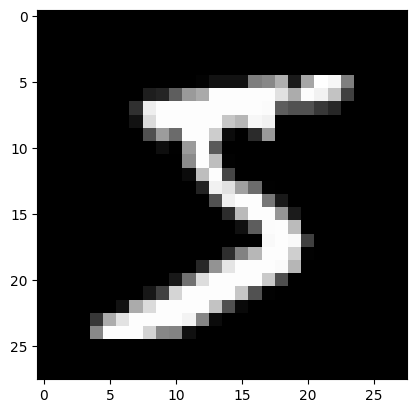

In [4]:
from matplotlib import pyplot as plt

img_index = 0

print(len(trainset)) # the size o training dataset 
print(trainset[img_index][0].shape, trainset[img_index][1]) # size spec, answer
plt.imshow(trainset[img_index][0][0], cmap='gray') # display an image

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.

그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.

마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

다음은 테스트 테이터셋 로더 설정입니다.

In [6]:
batch_size = 256 

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.

부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.

우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

torch.Size([256, 1, 28, 28]) torch.Size([256])


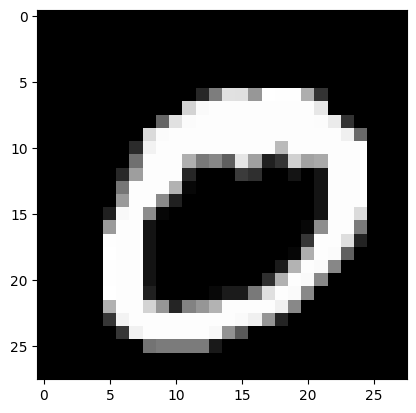

In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape, labels.shape)
plt.imshow(images[img_index][0], cmap='gray')

`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.

위에서 batch size를 256로 설정했기 때문에 총 256개의 image와 label들이 있어야 합니다.

실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

아래는 Classification를 적용한 코드입니다.

In [47]:
from torch import nn

class Model(nn.Module):
  def __init__(self, input_dim, h_dim, output_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, h_dim)
    self.layer2 = nn.Linear(h_dim, h_dim)
    self.layer3 = nn.Linear(h_dim, output_dim)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

  def accuracy(self, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = self(inputs)
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

    return acc / cnt


model = Model(28 * 28 * 1, 2048, 10)
criterion = nn.CrossEntropyLoss()

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.

여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.

`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.

이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.

이 역할을 수행하는 것이 바로 `torch.flatten`입니다.

우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [48]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 

다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.

MNIST부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [49]:
trainset_acc = []
testset_acc = []

n_epochs = 100

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs) # prediction
    loss = criterion(preds, labels) # loss function
    loss.backward() # calculate the gradient 
    optimizer.step() # update weight

    total_loss += loss.item()

  trainset_acc.append(model.accuracy(trainloader))
  testset_acc.append(model.accuracy(testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Accuracy: {testset_acc[-1]} ")

Epoch   0 | Loss: 538.1598541736603
Epoch   1 | Loss: 531.4871845245361
Epoch   2 | Loss: 524.6366550922394
Epoch   3 | Loss: 517.3468110561371
Epoch   4 | Loss: 509.35888266563416
Epoch   5 | Loss: 500.4463224411011
Epoch   6 | Loss: 490.34684705734253
Epoch   7 | Loss: 478.8568369150162
Epoch   8 | Loss: 465.71833980083466
Epoch   9 | Loss: 450.8031157255173
Epoch  10 | Loss: 434.01608657836914
Epoch  11 | Loss: 415.408164024353
Epoch  12 | Loss: 395.1734985113144
Epoch  13 | Loss: 373.7649276256561
Epoch  14 | Loss: 351.7675213813782
Epoch  15 | Loss: 329.89244866371155
Epoch  16 | Loss: 308.7102407217026
Epoch  17 | Loss: 288.7506580352783
Epoch  18 | Loss: 270.37269949913025
Epoch  19 | Loss: 253.6744601726532
Epoch  20 | Loss: 238.63230937719345
Epoch  21 | Loss: 225.2418057322502
Epoch  22 | Loss: 213.3782776594162
Epoch  23 | Loss: 202.7389605641365
Epoch  24 | Loss: 193.277425467968
Epoch  25 | Loss: 184.9203116297722
Epoch  26 | Loss: 177.48952305316925
Epoch  27 | Loss: 170.

학습의 정확도를 Plot 합니다.

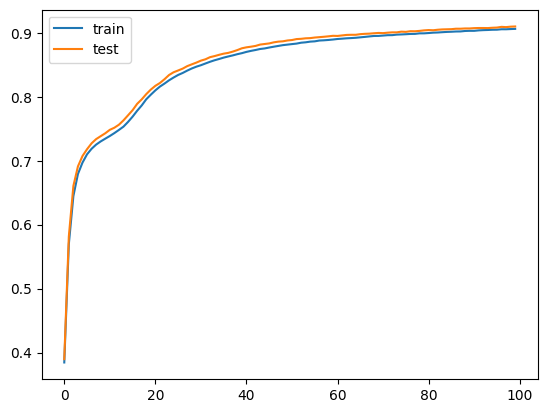

Max accuercy with train set: 90.61666666666667%
Max accuercy with test set: 90.99000000000001%


In [50]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(trainset_acc, testset_acc)

print(f'Max accuercy with train set: {max(trainset_acc)*100.}%')
print(f'Max accuercy with test set: {max(testset_acc)*100.}%')

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

tensor([[ 3.8627, -3.8389, -0.0467,  3.1356, -3.7523,  6.0209, -3.7585, -0.7518,
          1.6529, -2.4652]], device='cuda:0', grad_fn=<AddmmBackward0>)
5


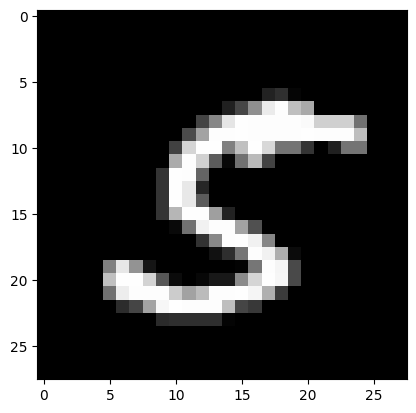

In [59]:
import random

idx = random.randint(0, len(trainset)-1) 

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda') # load data on GPU

print(model(x)) # inference in GPU
print(trainset[idx][1]) # get the answer in CPU
plt.imshow(trainset[idx][0][0], cmap='gray')